In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb

In [3]:
from src.dataset import load_team_data, load_agg_player_data
from src.preprocessing import impute_missing_values, split_data, remove_name_columns, encode_target_variable

team_statistics, y = load_team_data()
player_statistics = load_agg_player_data()

x = pd.concat([team_statistics, player_statistics], axis=1, join='inner')

In [4]:
x = remove_name_columns(x)
y = encode_target_variable(y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x, y)

x_train, imputer, columns = impute_missing_values(x_train)
x_val, _, _ = impute_missing_values(x_val, imputer=imputer, numeric_columns=columns)
x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=columns)

In [9]:
# --colsample_bylevel=0.4984424650238812 --colsample_bynode=0.9905597373489496 --colsample_bytree=0.36486202458245887 --early_stopping_rounds=20 --eta=0.26805672230829103 --gamma=6.68112740309121 --l1_reg=0.4707151922876891 --l2_reg=1.320921390316153 --max_delta_step=5.084675132974765 --max_depth=9 --max_leaves=2 --min_child_weight=0.8216661936802998 --num_boost_round=1620 --subsample=0.8203148837326393

sweep_result = {
    'colsample_bylevel': 0.4984424650238812,
    'colsample_bynode': 0.9905597373489496,
    'colsample_bytree': 0.36486202458245887,
    'eta': 0.26805672230829103,
    'gamma': 6.68112740309121,
    'l1_reg': 0.4707151922876891,
    'l2_reg': 1.320921390316153,
    'max_delta_step': 5.084675132974765,
    'max_depth': 9,
    'max_leaves': 2,
    'min_child_weight': 0.8216661936802998,
    'subsample': 0.8203148837326393

}
num_boost_round_sweep= 1620
early_stopping_rounds_sweep= 20

In [10]:
xgb_params = sweep_result

xgb_params["booster"] = "gbtree"
xgb_params["device"] = "cuda"
xgb_params["objective"] = "multi:softmax"
xgb_params["num_class"] = 3
xgb_params["eval_metric"] = "merror"
xgb_params["verbosity"] = 0

num_boost_round = num_boost_round_sweep
early_stopping_rounds = early_stopping_rounds_sweep

dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test, label=y_test)

evals = [(dtrain, "train"), (dval, "val")]

bst = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

[0]	train-merror:0.54515	val-merror:0.53530
[1]	train-merror:0.54490	val-merror:0.53428
[2]	train-merror:0.53499	val-merror:0.52819
[3]	train-merror:0.53106	val-merror:0.52006
[4]	train-merror:0.53118	val-merror:0.52108
[5]	train-merror:0.52902	val-merror:0.52057
[6]	train-merror:0.52674	val-merror:0.52158
[7]	train-merror:0.52242	val-merror:0.51346
[8]	train-merror:0.52318	val-merror:0.51193
[9]	train-merror:0.52051	val-merror:0.51397
[10]	train-merror:0.51950	val-merror:0.51143
[11]	train-merror:0.51962	val-merror:0.51143
[12]	train-merror:0.51746	val-merror:0.51041
[13]	train-merror:0.51543	val-merror:0.50838
[14]	train-merror:0.51581	val-merror:0.50787
[15]	train-merror:0.51404	val-merror:0.50635
[16]	train-merror:0.51518	val-merror:0.50279
[17]	train-merror:0.51467	val-merror:0.50025
[18]	train-merror:0.51340	val-merror:0.49975
[19]	train-merror:0.51327	val-merror:0.49721
[20]	train-merror:0.51175	val-merror:0.49975
[21]	train-merror:0.50934	val-merror:0.49924
[22]	train-merror:0.

In [11]:
from src.evaluate import evaluate_model

acc_val = evaluate_model(bst, dval, y_val)
acc_test = evaluate_model(bst, dtest, y_test)

print(f"Validation accuracy: {acc_val:.9f}")
print(f"Test accuracy: {acc_test:.9f}")

Validation accuracy: 0.505840528
Test accuracy: 0.498984153


In [85]:
from src.postprocessing import  compute_prediction, save_predictions

team_statistics = load_team_data(train=False)
player_statistics = load_agg_player_data(train=False)

x_test = pd.concat([team_statistics, player_statistics], axis=1, join='inner')
x_test = remove_name_columns(x_test)
x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=columns)

dtest = xgb.DMatrix(x_test)

y_pred = bst.predict(dtest, iteration_range=(0, bst.best_iteration))
predictions = compute_prediction(y_pred, x_test)

save_predictions(predictions, "xgboost_player.csv")

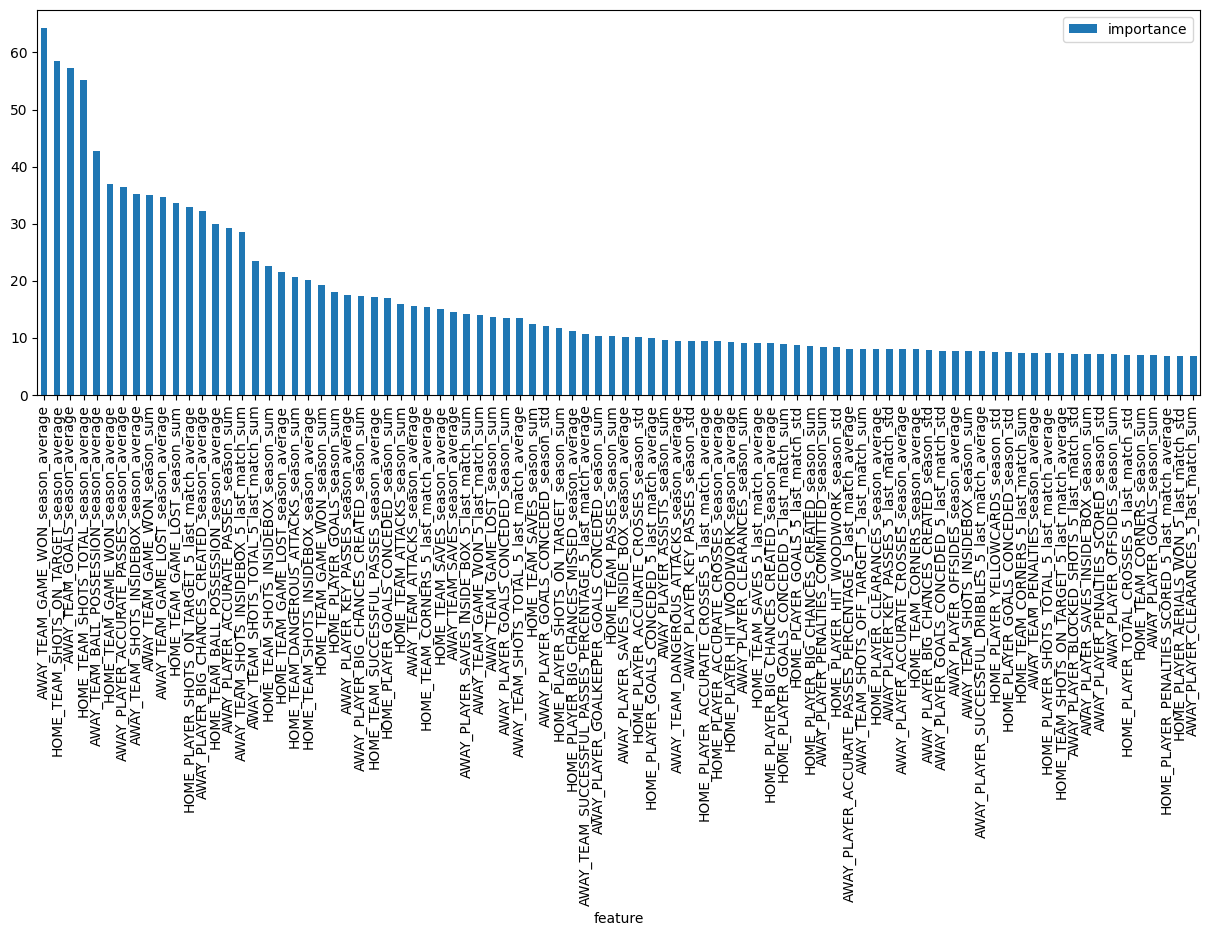

In [12]:
# get feature importance
feature_importance = bst.get_score(importance_type="gain")
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
feature_importance = pd.DataFrame(feature_importance, columns=["feature", "importance"])
feature_importance = feature_importance.set_index("feature")
feature_importance.plot(kind="bar", figsize=(15, 5))
plt.show()

In [20]:
features_used = list(feature_importance.index)

# get feature that appear both in the HOME and AWAY team
home_features = [f[5:] for f in features_used if f.startswith("HOME_")]
away_features = [f[5:] for f in features_used if f.startswith("AWAY_")]

print(f"Number of features used: {len(features_used)}")
print(f"Number of features used for HOME team: {len(home_features)}")   
print(f"Number of features used for AWAY team: {len(away_features)}")

Number of features used: 88
Number of features used for HOME team: 43
Number of features used for AWAY team: 45


In [31]:
[x for x in home_features if x in away_features]

['TEAM_GAME_WON_season_average',
 'TEAM_GAME_LOST_season_sum',
 'TEAM_BALL_POSSESSION_season_average',
 'TEAM_SHOTS_INSIDEBOX_season_sum',
 'TEAM_GAME_LOST_season_average',
 'TEAM_SHOTS_INSIDEBOX_season_average',
 'TEAM_GAME_WON_season_sum',
 'PLAYER_GOALS_season_sum',
 'PLAYER_GOALS_CONCEDED_season_sum',
 'TEAM_SAVES_season_average',
 'PLAYER_ACCURATE_CROSSES_season_average',
 'PLAYER_BIG_CHANCES_CREATED_season_average',
 'PLAYER_BIG_CHANCES_CREATED_season_sum',
 'PLAYER_GOALS_CONCEDED_season_std']